<a href="https://colab.research.google.com/github/AlexianL/StudentProject2023/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes = True)
sns.set(font_scale=1.5) # fixe la taille de la police à 1.5 * 12pt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Normalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.preprocessing import MinMaxScaler

Link google colab and google drive

In [18]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = "MyDrive/StudentProject2023"

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#Open AMA document
mass_file = open(join(PROJECT_PATH,"mass_1.mas20.txt"),"r+")

#Extract data from AMA mass data into a numpy array and csv file
#We should have 3378 entries in .csv doc, so 3377 elements in it

element_list = mass_file.readlines()

#We initialize our arrays : if we don't we can't use append() method
#We will supress these rows later
train_array = np.ones((1,12))
validation_array = np.ones((1,12))


#We create .csv files to use the pandas library later

train_mass_csv = open(join(PROJECT_PATH,"train_data.csv"),"w")
csv_header_row = "N-Z;N;Z;A;Mass_excess;ME_unc;BE/A;BE/A_unc;Beta_decay_Energy;BDE_unc;Atomic_Mass;AM_unc\n"
train_mass_csv.writelines(csv_header_row)

valid_mass_csv = open(join(PROJECT_PATH,"validation_data.csv"),"w")
valid_mass_csv.writelines(csv_header_row)


#The following lines are for the purpose of standardization of the data
#As the data is in a complicated format (some values are empty) and thus
#we need to process the data ourselves

for element in element_list :

    
    splitted_line = element.split() #Split a string separated by spaces
    #We will get a list of 15 elements in the end

    #All elements have a column with only "B-" written
    if splitted_line.index("B-") == 11 : 
        #We want to get rid of indices 0 and 6
        splitted_line.pop(0) 
        splitted_line.pop(5) #5 as index 0 is already removed by .pop(0)
    if splitted_line.index("B-") == 10 :
        if (int(splitted_line[1]) - int(splitted_line[2]) == int(splitted_line[0]) and 
            int(splitted_line[1]) + int(splitted_line[2]) == int(splitted_line[3])) :
            splitted_line.pop(5)
        else : #The only other possibility is 9 which is what we look for
            splitted_line.pop(0)
    if len(splitted_line) != 15 :
        #Beta-decay energies uncertainties are sometimes empty, we add a 0
        splitted_line.insert(11,"0") 
        

    
    #We get rid of element symbol and "B-" in the list
    #We now have list of 13 elements
    if splitted_line[10].find("*") != -1 :
        splitted_line[10] = "0" #Replace "*" by "0"
    splitted_line.pop(4) #Getting rid of element symbols
    splitted_line.pop(8) #Getting rid of "B-" string

    #Values for atomic_mass follow a strange format
    #We thus concatenate two columns
    #index 10 & 11
    atomic_mass_coma = splitted_line.pop(11)
    atomic_mass_coma = "." + atomic_mass_coma.replace(".","")
    splitted_line[10] = splitted_line[10] + atomic_mass_coma
    
    
    #We now have list of 12 elements

    #Remove "#" and standardization of the list in order to convert into array
    for i in range(12) :
        if splitted_line[i].find("#") != -1 :
            splitted_line[i] = splitted_line[i].replace("#","")

    if (int(splitted_line[2]) == 10 or
        int(splitted_line[2]) == 38 or
        int(splitted_line[2]) == 54 or
        int(splitted_line[2]) == 68 or
        int(splitted_line[2]) == 82) :
        valid_mass_csv.writelines(";".join(splitted_line) + "\n")

        for i in range(12) :
            splitted_line[i] = np.double(splitted_line[i])

        validation_array = np.vstack([validation_array,np.asarray(splitted_line)])
        continue

    train_mass_csv.writelines(";".join(splitted_line) + "\n")
    
    #We have to use the same loop again as mass_csv need string and 
    #train_array need double format
    for i in range(12) :
        splitted_line[i] = np.double(splitted_line[i])

    train_array = np.vstack([train_array,np.asarray(splitted_line)])

#We suppress the first rows of our arrays
train_array = np.delete(train_array,0,0)
validation_array = np.delete(validation_array,0,0)

Check if tensorflow is well configured and if it detects your GPU

In [20]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs available:  1


In [21]:
#We extract a keras train dataset from the .csv file
#Batch_size=11 because it is a divisor of 3377 (could have been 307)
#Talk about pros and cons of small batch size ?
#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network


train_data = pd.read_csv(join(PROJECT_PATH,"train_data.csv"),sep=";")

target = train_data["BE/A"]
n_input = train_data["N"]
z_input = train_data["Z"]

#ANN work best when using data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_n = scaler.fit_transform(pd.Series.to_numpy(n_input).reshape(-1,1))
scaled_z = scaler.fit_transform(pd.Series.to_numpy(z_input).reshape(-1,1))
scaled_target = scaler.fit_transform(pd.Series.to_numpy(target).reshape(-1,1))



In [22]:
#ANN Model

input1 = keras.layers.Input(shape=(1,))
input2 = keras.layers.Input(shape=(1,))
merged = keras.layers.Concatenate()([input1, input2])
dense1 = keras.layers.Dense(16, input_dim=2, activation="tanh")(merged)
dense2 = keras.layers.Dense(16, activation="tanh")(dense1)
output = keras.layers.Dense(1, activation="sigmoid")(dense2)
model = keras.models.Model(([input1, input2]),output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 2)            0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 16)           48          ['concatenate_1[0][0]']    

Epoch 1/100
308/308 - 1s - loss: 0.0950 - 915ms/epoch - 3ms/step
Epoch 2/100
308/308 - 1s - loss: 0.0337 - 587ms/epoch - 2ms/step
Epoch 3/100
308/308 - 1s - loss: 0.0151 - 611ms/epoch - 2ms/step
Epoch 4/100
308/308 - 1s - loss: 0.0089 - 612ms/epoch - 2ms/step
Epoch 5/100
308/308 - 1s - loss: 0.0066 - 594ms/epoch - 2ms/step
Epoch 6/100
308/308 - 1s - loss: 0.0056 - 611ms/epoch - 2ms/step
Epoch 7/100
308/308 - 1s - loss: 0.0052 - 624ms/epoch - 2ms/step
Epoch 8/100
308/308 - 1s - loss: 0.0051 - 632ms/epoch - 2ms/step
Epoch 9/100
308/308 - 1s - loss: 0.0050 - 612ms/epoch - 2ms/step
Epoch 10/100
308/308 - 1s - loss: 0.0050 - 600ms/epoch - 2ms/step
Epoch 11/100
308/308 - 1s - loss: 0.0049 - 598ms/epoch - 2ms/step
Epoch 12/100
308/308 - 1s - loss: 0.0049 - 575ms/epoch - 2ms/step
Epoch 13/100
308/308 - 1s - loss: 0.0049 - 605ms/epoch - 2ms/step
Epoch 14/100
308/308 - 1s - loss: 0.0048 - 596ms/epoch - 2ms/step
Epoch 15/100
308/308 - 1s - loss: 0.0048 - 606ms/epoch - 2ms/step
Epoch 16/100
308/30

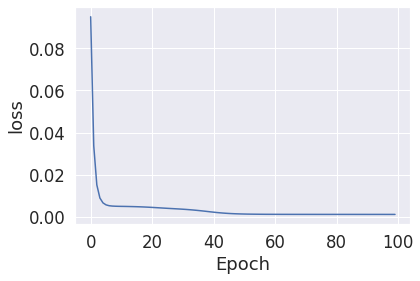

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error")

history=model.fit(x=([scaled_n,scaled_z]), y=scaled_target,batch_size=11, epochs=100, shuffle=True, verbose=2)

plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

In [24]:
#We extract a keras testset from the .csv file
#Batch_size=11 because it is a divisor of 3377 (could have been 307)
#Talk about pros and cons of small batch size ?
#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

validation_data = pd.read_csv(join(PROJECT_PATH,"validation_data.csv"),sep=";")



test_target = validation_data["BE/A"]
test_n_input = validation_data["N"]
test_z_input = validation_data["Z"]

scaler = MinMaxScaler(feature_range=(0,1))
test_scaled_n = scaler.fit_transform(pd.Series.to_numpy(test_n_input).reshape(-1,1))
test_scaled_z = scaler.fit_transform(pd.Series.to_numpy(test_z_input).reshape(-1,1))
test_scaled_target = scaler.fit_transform(pd.Series.to_numpy(test_target).reshape(-1,1))



In [25]:
#Predictions thanks to our ANN

validation_predictions = model.predict(x=([test_scaled_n,test_scaled_z]),
                                       batch_size=1, verbose=0)

train_predictions = model.predict(x=([scaled_n,scaled_z]),
                                       batch_size=1, verbose=0)

In [26]:
rescaled_vp = [(i - scaler.min_)/scaler.scale_ for i in validation_predictions]
rescaled_tp = [(i - scaler.min_)/scaler.scale_ for i in train_predictions]

#Create a new column with the predictions
validation_data["BE/A_Predictions"] = np.double(rescaled_vp)

#Create a new column with the difference between experimental and ANN data
validation_data["Difference"] = validation_data["BE/A"] - validation_data["BE/A_Predictions"]

#We do the same for training data
train_data["BE/A_Predictions"] = np.double(rescaled_tp)
train_data["Difference"] = train_data["BE/A"] - train_data["BE/A_Predictions"]


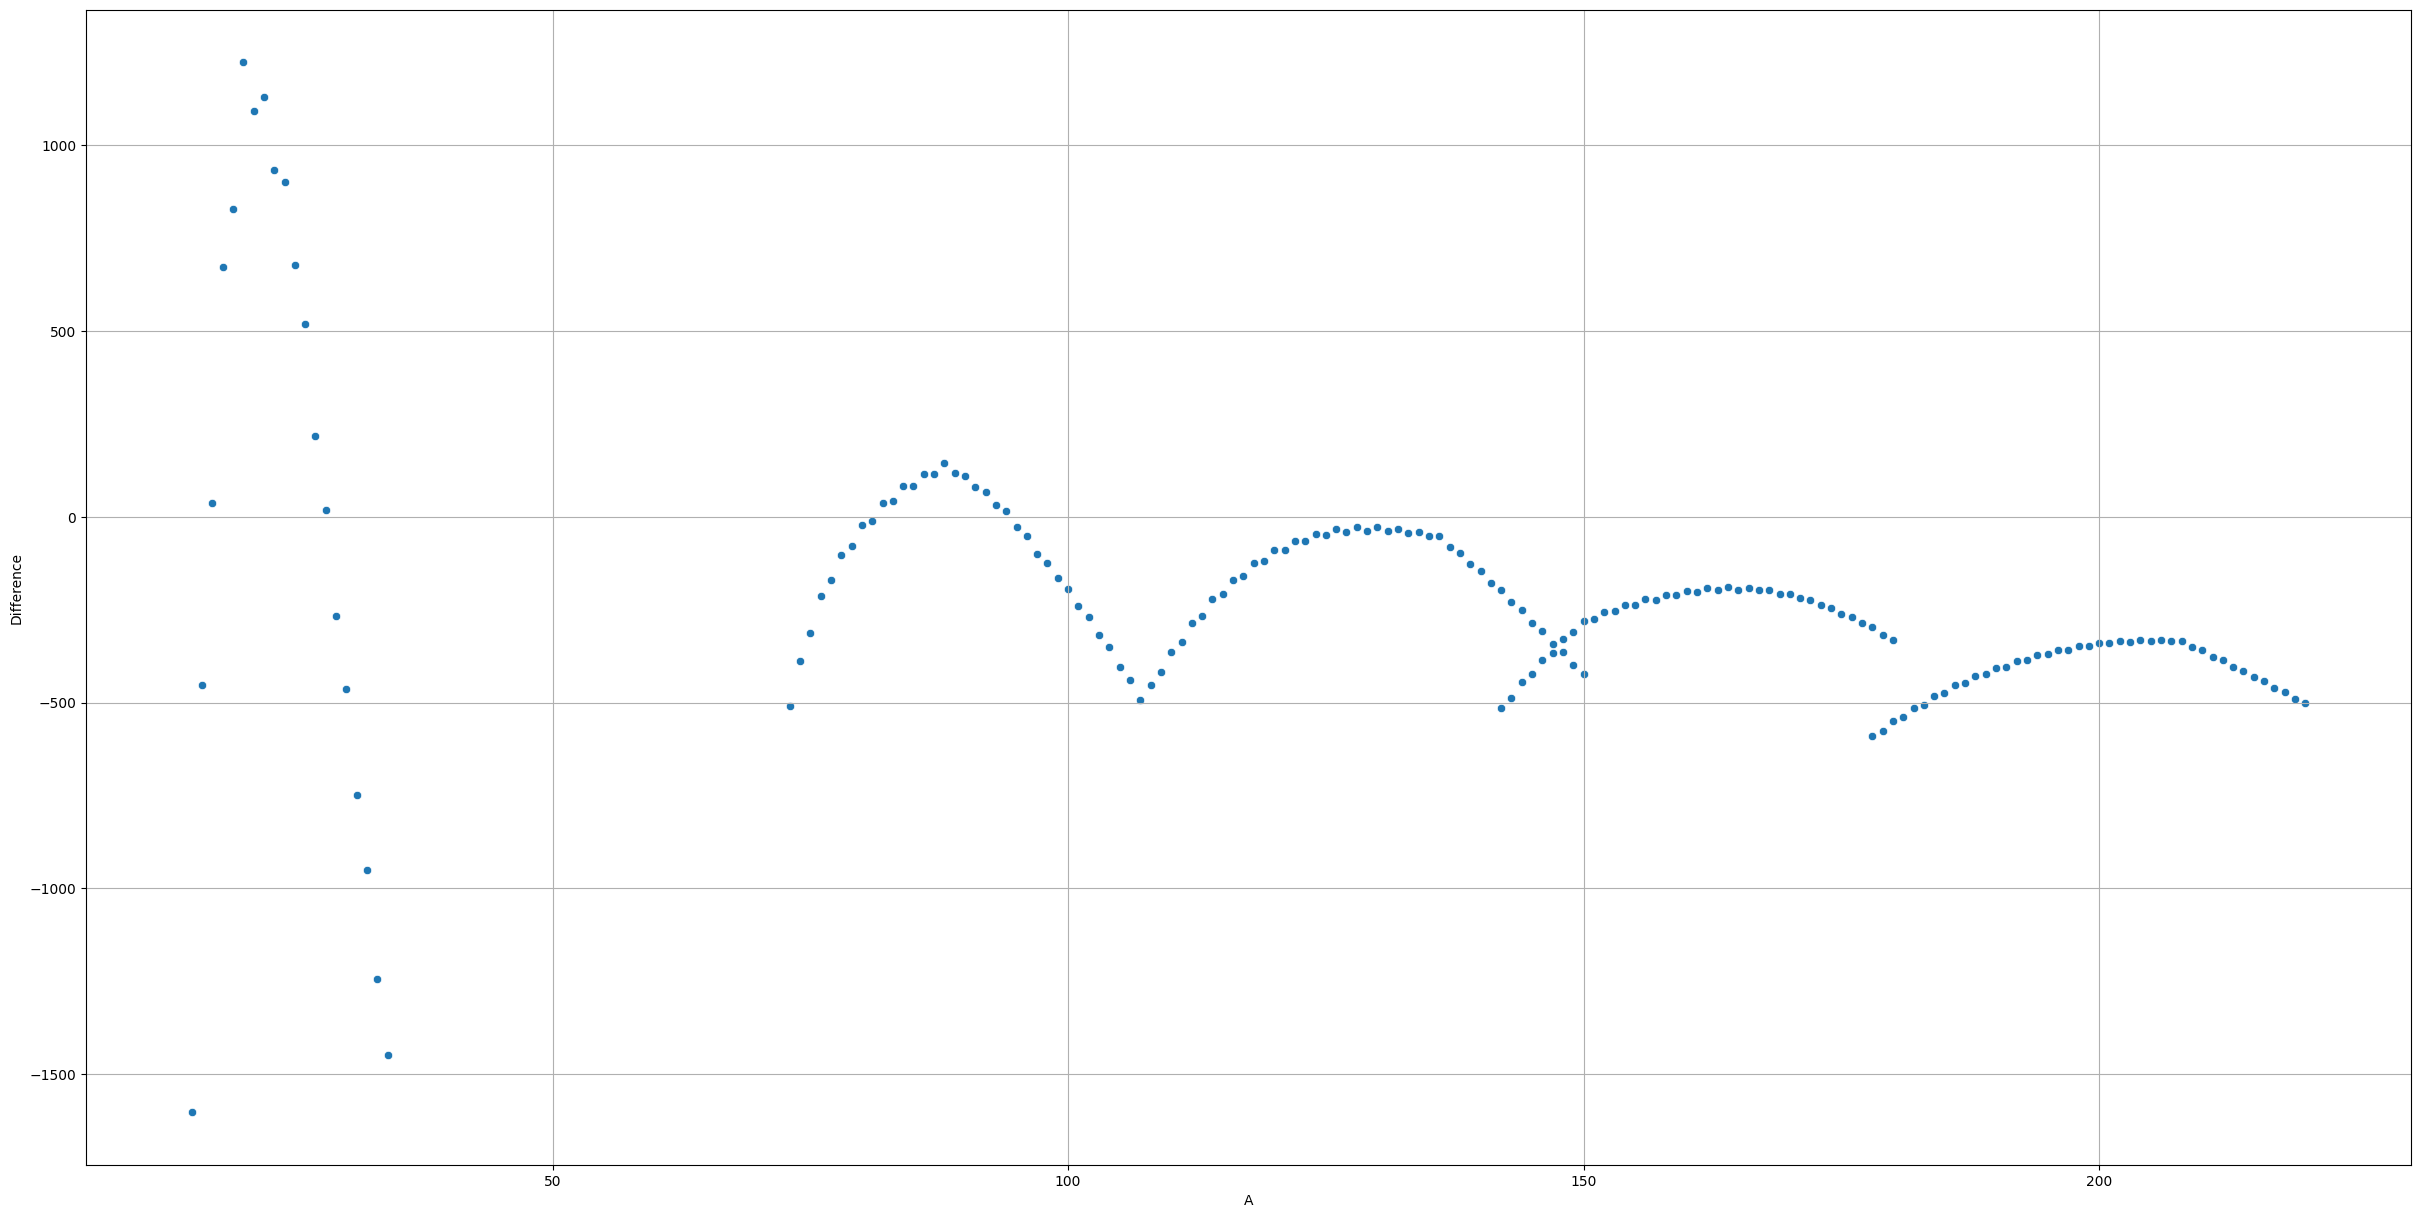

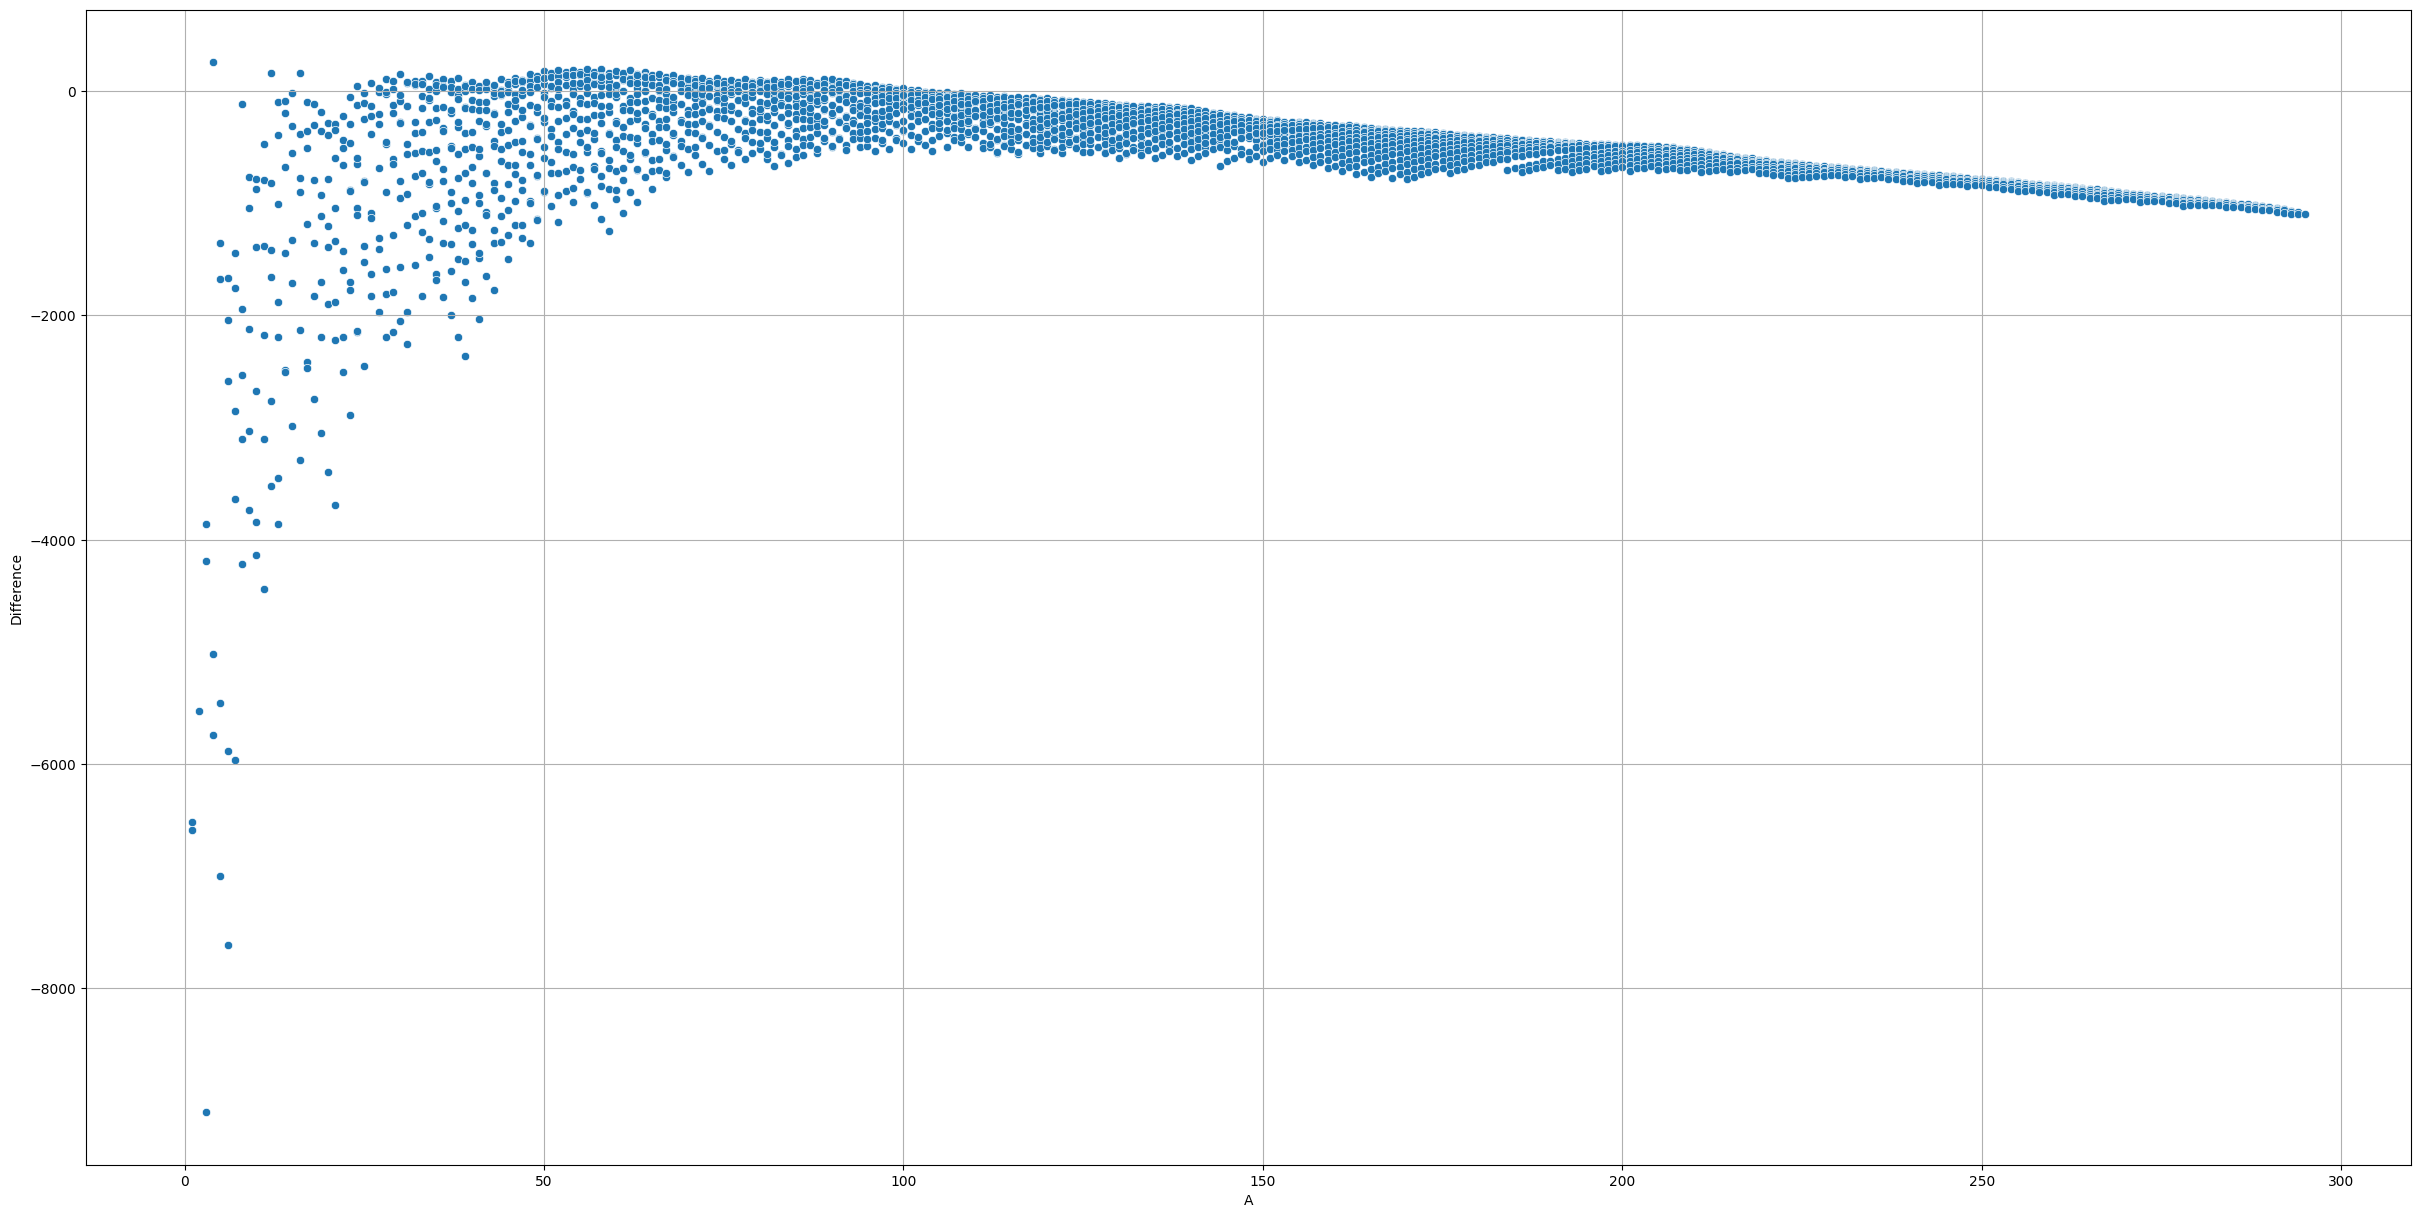

In [27]:

with plt.style.context('default'):
    plt.figure(figsize =(30,15))
    plt.grid()
    sns.scatterplot(x="A",y="Difference", data=validation_data, palette="rainbow_r")
    


with plt.style.context('default'):
    plt.figure(figsize =(30,15))
    plt.grid()
    sns.scatterplot(x="A",y="Difference", data=train_data, palette="rainbow_r")

In [28]:
print(train_data[train_data["Z"]==11][train_data["N"]==11].index.values[0])


114


<ipython-input-28-c74000949df0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train_data[train_data["Z"]==11][train_data["N"]==11].index.values[0])


In [29]:
#Create the two neutron separation energy column

#To hide warnings because sometimes we don't have the n-2 data
#Thus we can't subtract
%%capture --no-display

diff_n=[0 for i in range(3378)]

for i in range(0,119) :
    for j in train_data["N"][train_data["Z"]==i]:
        n=train_data[train_data["Z"]==i][train_data["N"]==j]
        n_minus_two=train_data[train_data["Z"]==i][train_data["N"]==j-2]
        index=n.index.values[0]
        sub=np.double(n["BE/A"])-np.double(n_minus_two["BE/A"])
        if type(sub)==np.double :
            diff_n[index]=sub
        else :
            diff_n[index]=0



train_data["S2n"]=diff_n

#Same for the two proton separation energy

diff_z=[0 for i in range(3378)]

for i in range(0,178) :
    for j in train_data["Z"][train_data["N"]==i]:
        z=train_data[train_data["N"]==i][train_data["Z"]==j]
        z_minus_two=train_data[train_data["N"]==i][train_data["Z"]==j-2]
        index=z.index.values[0]
        sub=np.double(z["BE/A"])-np.double(z_minus_two["BE/A"])
        if type(sub)==np.double :
            diff_z[index]=sub
        else :
            diff_z[index]=0

train_data["S2z"]=diff_z






In [30]:
train_data.head(10)

,N-Z,N,Z,A,Mass_excess,ME_unc,BE/A,BE/A_unc,Beta_decay_Energy,BDE_unc,Atomic_Mass,AM_unc,BE/A_Predictions,Difference,S2n,S2z
0,1,1,0,1,8071.318060,0.000440,0.00000,0.00000,782.34700,0.00040,1.008665,0.000470,6519.468953,-6519.468953,0.0000,0.00000
1,-1,0,1,1,7288.971064,0.000013,0.00000,0.00000,0.00000,0.00000,1.007825,0.000014,6589.195464,-6589.195464,0.0000,0.00000
2,0,1,1,2,13135.722895,0.000015,1112.28310,0.00020,0.00000,0.00000,2.014102,0.000015,6639.715045,-5527.431945,0.0000,0.00000
3,1,2,1,3,14949.810900,0.000080,2827.26540,0.00030,18.59202,0.00006,3.016049,0.000080,6690.971025,-3863.705625,2827.2654,0.00000
4,-1,1,2,3,14931.218880,0.000060,2572.68044,0.00015,-13736.00000,2000.00000,3.016029,0.000060,6763.733409,-4191.052969,0.0000,2572.68044
5,-3,0,3,3,28667.000000,2000.000000,-2267.00000,667.00000,0.00000,0.00000,3.030775,2147.000000,6837.244858,-9104.244858,0.0000,-2267.00000
6,2,3,1,4,24621.129000,100.000000,1720.44910,25.00000,22196.21310,100.00000,4.026432,107.354000,6742.866100,-5022.417000,608.1660,0.00000
7,0,2,2,4,2424.915870,0.000150,7073.91560,0.00020,-22898.27400,212.13200,4.002603,0.000160,6816.265045,257.650555,0.0000,0.00000
8,-2,1,3,4,25323.190000,212.132000,1153.76030,53.03300,0.00000,0.00000,4.027186,227.733000,6890.212806,-5736.452506,0.0000,41.47720
9,3,4,1,5,32892.447000,89.443000,1336.35920,17.88850,21661.21310,91.65150,5.035311,96.020000,6795.296287,-5458.937087,-1490.9062,0.00000
